In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools
import numpy as np
import gudhi as gh
import networkx as nx
import matplotlib.pyplot as plt

from src.depth import DepthPoset

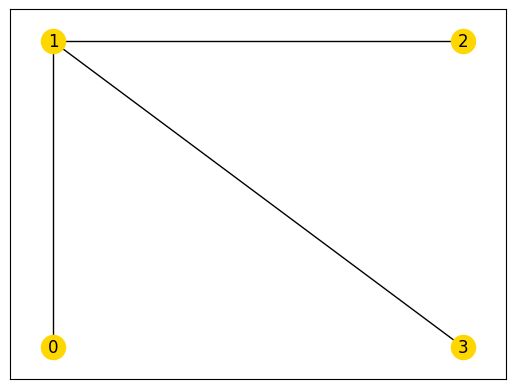

In [3]:
g = nx.Graph()
g.add_nodes_from([0, 1, 2, 3])
g.add_edges_from([(0, 1), (1, 2), (1, 3)])
g_pos = {0: np.array([-1., -1.]),
         1: np.array([-1.,  1.]), 
         2: np.array([ 1.,  1.]), 
         3: np.array([ 1., -1.])
}
g_pos.update({(key, ): g_pos[key] for key in g_pos.keys()})
g_pos.update({(key0, key1): 0.5*(g_pos[key0] + g_pos[key1]) for key0, key1 in itertools.product(g_pos.keys(), repeat=2)})
    
nx.draw_networkx(g, node_color='gold', pos=g_pos)

In [4]:
def draw_segment_area_border(p0, p1, r=1, n=120):
    # 
    p0, p1 = np.array([p0, p1])
    vector = p1 - p0
    normal = np.array([vector[1], -vector[0]])
    normal = normal/np.linalg.norm(normal)

    x0, y0 = np.array([p0 + r*normal, p1 + r*normal]).transpose()
    x2, y2 = np.array([p0 - r*normal, p1 - r*normal]).transpose()

    x1, y1 = np.array([p1 + r*normal@np.array([[ np.cos(alpha), np.sin(alpha)], 
                                               [-np.sin(alpha), np.cos(alpha)]]) for alpha in np.pi*np.arange(1, n)/n]).transpose()
    
    x3, y3 = np.array([p0 - r*normal@np.array([[ np.cos(alpha), np.sin(alpha)], 
                                               [-np.sin(alpha), np.cos(alpha)]]) for alpha in (np.pi*np.arange(1, n)/n)]).transpose()

    x = np.concatenate([x0, x1, np.flip(x2), x3, ])
    y = np.concatenate([y0, y1, np.flip(y2), y3, ])
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    return x, y

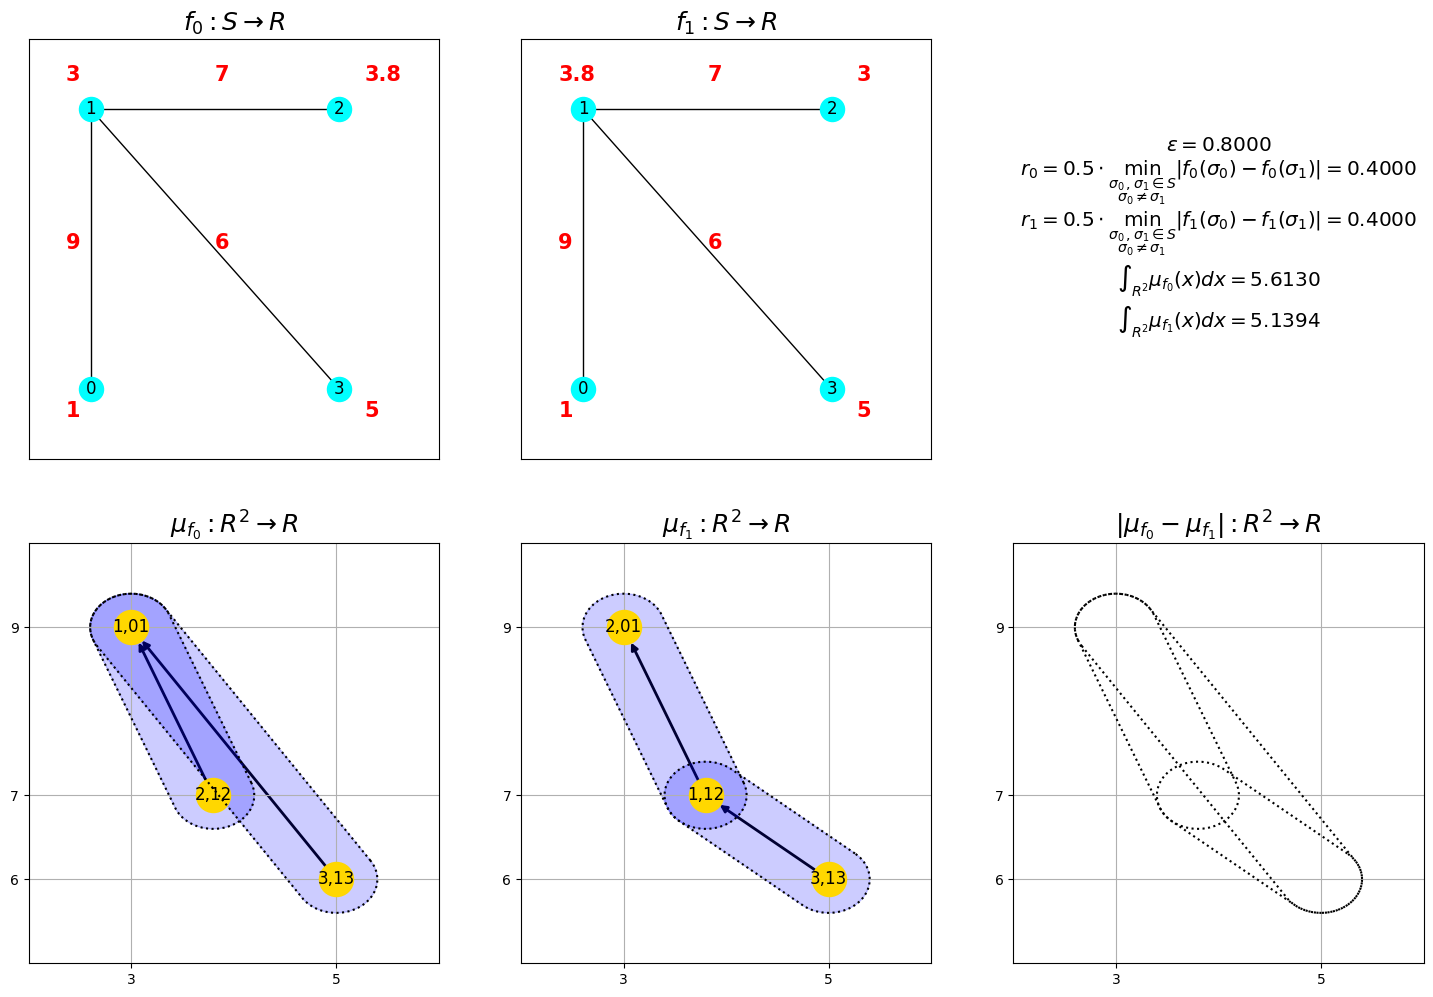

In [5]:
eps = 0.8

r_coeff = 0.5
r = 0.5*eps

filtration0 = {(0, ): 1, (1, ): 3, (2, ): 3 + eps, (3, ): 5, (0, 1): 9, (1, 2): 7, (1, 3): 6}
filtration1 = {(0, ): 1, (1, ): 3 + eps, (2, ): 3, (3, ): 5, (0, 1): 9, (1, 2): 7, (1, 3): 6}

stree0 = gh.SimplexTree()
for simplex, filtration_value in filtration0.items():
    stree0.insert(simplex, filtration_value)
    
stree1 = gh.SimplexTree()
for simplex, filtration_value in filtration1.items():
    stree1.insert(simplex, filtration_value)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)


fig, axs = plt.subplots(2, 3)
fig.set_figwidth(18)
fig.set_figheight(12)

l0 = (2**2 + eps**2)**0.5
l1 = ((2 - eps)**2 + 1**2)**0.5
l2 = (2**2 + 3**2)**0.5
s0 = 2*r*l0 + np.pi*r**2
s1 = 2*r*l1 + np.pi*r**2
s2 = 2*r*l2 + np.pi*r**2

description = f'''$\\varepsilon = {eps:.4f}$
$r_0 = {r_coeff}\\cdot\\min_{{\\substack{{\\sigma_0, \\sigma_1 \\in S \\\\ \\sigma_0 \\ne \\sigma_1}}}} |f_0(\\sigma_0) - f_0(\\sigma_1)| = {r:.4f}$
$r_1 = {r_coeff}\\cdot\\min_{{\\substack{{\\sigma_0, \\sigma_1 \\in S \\\\ \\sigma_0 \\ne \\sigma_1}}}} |f_1(\\sigma_0) - f_1(\\sigma_1)| = {r:.4f}$
$\\int_{{R^2}} \\mu_{{f_0}}(x) dx = {s0 + s2:.4f}$
$\\int_{{R^2}} \\mu_{{f_1}}(x) dx = {s1 + s2:.4f}$
'''
axs[0, 2].text(0.5, 0.5, description, fontsize='x-large', va='center', ha='center')
axs[0, 2].axis('off')

nx.draw_networkx(g, node_color='cyan', pos=g_pos, ax=axs[0, 0])
for key in filtration0.keys():
    x, y = g_pos[key]*1.2
    axs[0, 0].text(x, y, f'{filtration0[key]}', color='red', weight='bold', size=15)
axs[0, 0].set_xlim(-1.5, 1.8)
axs[0, 0].set_ylim(-1.5, 1.5)

nx.draw_networkx(g, node_color='cyan', pos=g_pos, ax=axs[0, 1])
for key in filtration0.keys():
    x, y = g_pos[key]*1.2
    axs[0, 1].text(x, y, f'{filtration1[key]}', color='red', weight='bold', size=15)
axs[0, 1].set_xlim(-1.5, 1.8)
axs[0, 1].set_ylim(-1.5, 1.5)

axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

labels0 = {node: f'{node.source[0][0]},{node.source[1][0]}{node.source[1][1]}' for node in dp0.nodes}
graph0 = dp0.get_transitive_reduction()
pos0 = dp0.persistant_layout()
nx.draw_networkx(graph0, pos=pos0, ax=axs[1, 0], labels=labels0, 
                 hide_ticks=False, node_color='gold', node_size=600, width=2)
for n0, n1 in graph0.edges:
    p0 = pos0[n0]
    p1 = pos0[n1]
    x, y = draw_segment_area_border(p0, p1, r=r)
    axs[1, 0].plot(x, y, color='black', linestyle=':')
    axs[1, 0].fill(x, y, color='blue',alpha=0.2)
    

labels1 = {node: f'{node.source[0][0]},{node.source[1][0]}{node.source[1][1]}' for node in dp1.nodes}
graph1 = dp1.get_transitive_reduction()
pos1 = dp1.persistant_layout()
nx.draw_networkx(graph1, pos=pos1, ax=axs[1, 1], labels=labels1, 
                 hide_ticks=False, node_color='gold', node_size=600, width=2)
for n0, n1 in graph1.edges:
    p0 = pos1[n0]
    p1 = pos1[n1]
    x, y = draw_segment_area_border(p0, p1, r=r)
    axs[1, 1].plot(x, y, color='black', linestyle=':')
    axs[1, 1].fill(x, y, color='blue',alpha=0.2)

for p0, p1 in itertools.combinations([(3, 9), (5, 6), (3 + eps, 7)], 2):
    x, y = draw_segment_area_border(p0, p1, r=r)
    axs[1, 2].plot(x, y, color='black', linestyle=':')

for i in range(3):
    axs[1, i].set_xlim(2, 6)
    axs[1, i].set_ylim(5, 10)
    axs[1, i].set_xticks([3, 5])
    axs[1, i].set_yticks([6, 7, 9])
    axs[1, i].grid(True)

axs[0, 0].set_title(r'$f_0: S\to R$', size=18)
axs[0, 1].set_title(r'$f_1: S\to R$', size=18)
axs[1, 0].set_title(r'$\mu_{f_0}: R^2\to R$', size=18)
axs[1, 1].set_title(r'$\mu_{f_1}: R^2\to R$', size=18)
axs[1, 2].set_title(r'$|\mu_{f_0} - \mu_{f_1}|: R^2\to R$', size=18)

plt.show()

In [6]:
from shapely.geometry import Polygon

def polygon_intersection(x_list, y_list):
    """
    Computes the intersection of multiple polygons.
    
    Parameters:
    - x_list: List of arrays, each containing x-coordinates of a polygon's vertices.
    - y_list: List of arrays, each containing y-coordinates of a polygon's vertices.
    
    Returns:
    - (x, y): Coordinates of the intersected polygon as two arrays.
    - None: If there is no intersection.
    """
    # Convert x, y coordinates to Shapely polygons
    polygons = [Polygon(zip(x, y)) for x, y in zip(x_list, y_list)]
    
    # Compute the intersection of all polygons
    intersection = polygons[0]
    for poly in polygons[1:]:
        intersection = intersection.intersection(poly)
        if intersection.is_empty:
            return None  # No intersection exists

    # Convert the intersection polygon back to x, y coordinates
    if intersection.is_empty:
        return None
    else:
        x, y = intersection.exterior.coords.xy
        return np.array(x), np.array(y)


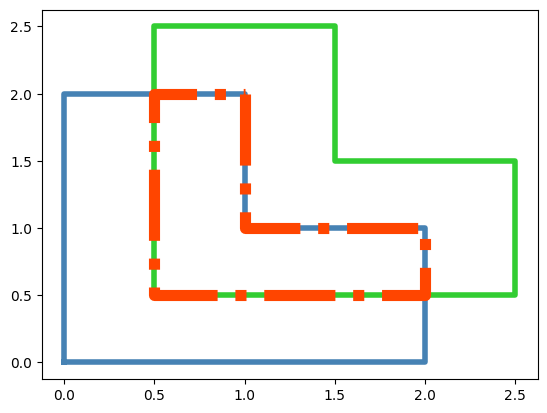

In [7]:
x0, y0 = np.array([[0, 2, 2, 1, 1, 0, 0], [0, 0, 1, 1, 2, 2, 0]]) + 0.0
x1, y1 = x0 + 0.5, y0 + 0.5



plt.plot(x0, y0, linewidth=4, color='steelblue')
plt.plot(x1, y1, linewidth=4, color='limegreen')

result = polygon_intersection([x0, x1], [y0, y1])
if result is not None:
    x2, y2 = result
    x2 = np.append(x2, x2[0])
    y2 = np.append(y2, y2[0])
    plt.plot(x2, y2, linestyle='-.', linewidth=8, color='orangered')


Intersection coordinates: [1.  1.5 1.5 1.  1. ] [2.  2.  1.5 1.5 2. ]


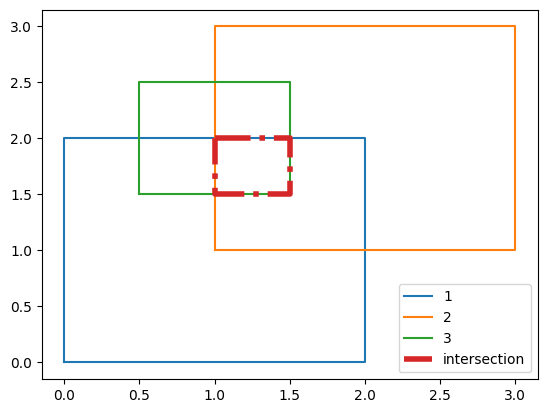

In [8]:
# Example polygons
x1, y1 = np.array([0, 2, 2, 0]), np.array([0, 0, 2, 2])
x2, y2 = np.array([1, 3, 3, 1]), np.array([1, 1, 3, 3])
x3, y3 = np.array([0.5, 1.5, 1.5, 0.5]), np.array([1.5, 1.5, 2.5, 2.5])

# Compute intersection
result = polygon_intersection([x1, x2, x3], [y1, y2, y3])

# Display result
if result is not None:
    x_inter, y_inter = result
    print("Intersection coordinates:", x_inter, y_inter)
else:
    print("No intersection exists.")

x1 = np.append(x1, x1[0])
y1 = np.append(y1, y1[0])
x2 = np.append(x2, x2[0])
y2 = np.append(y2, y2[0])
x3 = np.append(x3, x3[0])
y3 = np.append(y3, y3[0])
x_inter = np.append(x_inter, x_inter[0])
y_inter = np.append(y_inter, y_inter[0])

plt.plot(x1, y1, label=1)
plt.plot(x2, y2, label=2)
plt.plot(x3, y3, label=3)
plt.plot(x_inter, y_inter, label='intersection', linestyle='-.', linewidth=4)

plt.legend()
plt.show()


Intersection coordinates: [1.  1.  2.  2.  0.5 0.5 1. ] [2.  1.  1.  0.5 0.5 2.  2. ]


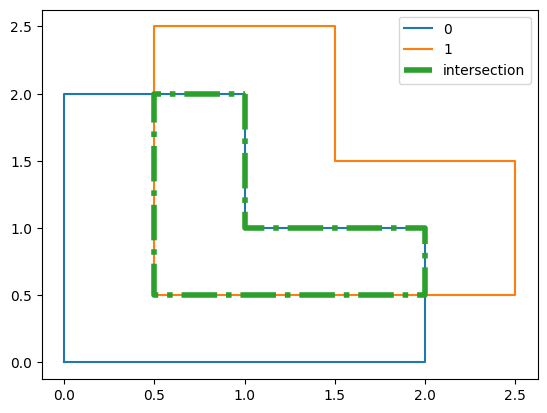

In [9]:
x0, y0 = np.array([[0, 2, 2, 1, 1, 0, 0], [0, 0, 1, 1, 2, 2, 0]]) + 0.0
x1, y1 = x0 + 0.5, y0 + 0.5


# Compute intersection
result = polygon_intersection([x0, x1], [y0, y1])

# Display result
if result is not None:
    x_inter, y_inter = result
    print("Intersection coordinates:", x_inter, y_inter)
else:
    print("No intersection exists.")

x0 = np.append(x0, x0[0])
y0 = np.append(y0, y0[0])
x1 = np.append(x1, x1[0])
y1 = np.append(y1, y1[0])
x_inter = np.append(x_inter, x_inter[0])
y_inter = np.append(y_inter, y_inter[0])

plt.plot(x0, y0, label=0)
plt.plot(x1, y1, label=1)
plt.plot(x_inter, y_inter, label='intersection', linestyle='-.', linewidth=4)

plt.legend()
plt.show()